window = 100
epoch = 20
batch = 100
dropout = .02

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
!pwd

/Users/josephbarry/Desktop/FinTech_Class/3rd_Project/FinTech_Portfolio_Dash/JGB_Notebook


In [3]:
csvpath = Path("MU.csv")

df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-08-16,6.41,6.47,6.19,6.29,6.29,20070200
2011-08-17,6.35,6.41,6.07,6.11,6.11,29669900
2011-08-18,5.88,5.89,5.60,5.64,5.64,45540000
2011-08-19,5.50,5.66,5.20,5.25,5.25,49901300
2011-08-22,5.41,5.52,5.22,5.26,5.26,35010000


In [4]:
df = df[['Close']]
df

,Close
Date,
2011-08-16,6.290000
2011-08-17,6.110000
2011-08-18,5.640000
2011-08-19,5.250000
2011-08-22,5.260000
...,...
2021-08-09,80.209999
2021-08-10,75.910004
2021-08-11,75.029999


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[6.29 6.11 5.64 5.25 5.26 5.66 5.3  5.38 5.66 6.15 5.95 5.91 5.74 5.5
  5.67 6.06 6.25 6.35 6.69 6.86 7.2  7.04 7.03 6.88 6.85 6.61 6.43 6.65
  6.58 6.46 6.12 5.87 5.04 4.33 4.52 4.95 4.96 4.95 5.16 5.2  5.2  5.52
  5.7  5.44 5.77 5.53 5.59 5.46 5.66 5.49 5.47 5.7  5.88 5.59 5.29 5.43
  5.84 5.89 5.85 5.91 5.35 5.18 5.43 5.35 5.46 6.74 6.33 6.29 6.09 6.1
  5.71 5.5  5.62 5.64 5.99 5.89 5.8  5.73 5.65 6.06 5.82 5.89 5.82 5.61
  5.45 5.55 5.68 5.45 5.79 5.54 6.41 6.4  6.25 6.17 6.27 6.29 6.76 6.99
  7.16 7.2 ]
 [6.11 5.64 5.25 5.26 5.66 5.3  5.38 5.66 6.15 5.95 5.91 5.74 5.5  5.67
  6.06 6.25 6.35 6.69 6.86 7.2  7.04 7.03 6.88 6.85 6.61 6.43 6.65 6.58
  6.46 6.12 5.87 5.04 4.33 4.52 4.95 4.96 4.95 5.16 5.2  5.2  5.52 5.7
  5.44 5.77 5.53 5.59 5.46 5.66 5.49 5.47 5.7  5.88 5.59 5.29 5.43 5.84
  5.89 5.85 5.91 5.35 5.18 5.43 5.35 5.46 6.74 6.33 6.29 6.09 6.1  5.71
  5.5  5.62 5.64 5.99 5.89 5.8  5.73 5.65 6.06 5.82 5.89 5.82 5.61 5.45
  5.55 5.68 5.45 5.79 5.54 6.41 6.4  

In [7]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
#x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
#y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
#x_test_scaler.fit(X_test)
#y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [9]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [12]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [13]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 81ms/step - loss: 0.0082
Epoch 2/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0188
Epoch 3/20
15/15 [==============================] - 1s 78ms/step - loss: 0.0287
Epoch 4/20
15/15 [==============================] - 1s 78ms/step - loss: 0.0054
Epoch 5/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0035
Epoch 6/20
15/15 [==============================] - 1s 74ms/step - loss: 0.0047
Epoch 7/20
15/15 [==============================] - 1s 83ms/step - loss: 0.0026
Epoch 8/20
15/15 [==============================] - 1s 95ms/step - loss: 0.0022
Epoch 9/20
15/15 [==============================] - 1s 79ms/step - loss: 0.0023
Epoch 10/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0029
Epoch 11/20
15/15 [==============================] - 1s 75ms/step - loss: 0.0027
Epoch 12/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0022
Epoch 13/20
15/15 [==================

In [14]:
model.evaluate(X_test, y_test, verbose=0)

0.16743412613868713

In [15]:
predicted = model.predict(X_test)

In [16]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [17]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [18]:
actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_predicted.head()

,Actual,Predicted
Date,,
2017-10-12,41.610001,33.828270
2017-10-13,40.580002,34.122353
2017-10-16,40.400002,34.388111
2017-10-17,41.490002,34.610458
2017-10-18,40.389999,34.804520


In [19]:
actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,82.000000,51.544605
2021-08-10,80.209999,51.696751
2021-08-11,75.910004,51.838814
2021-08-12,75.029999,51.922932
2021-08-13,70.250000,51.941837


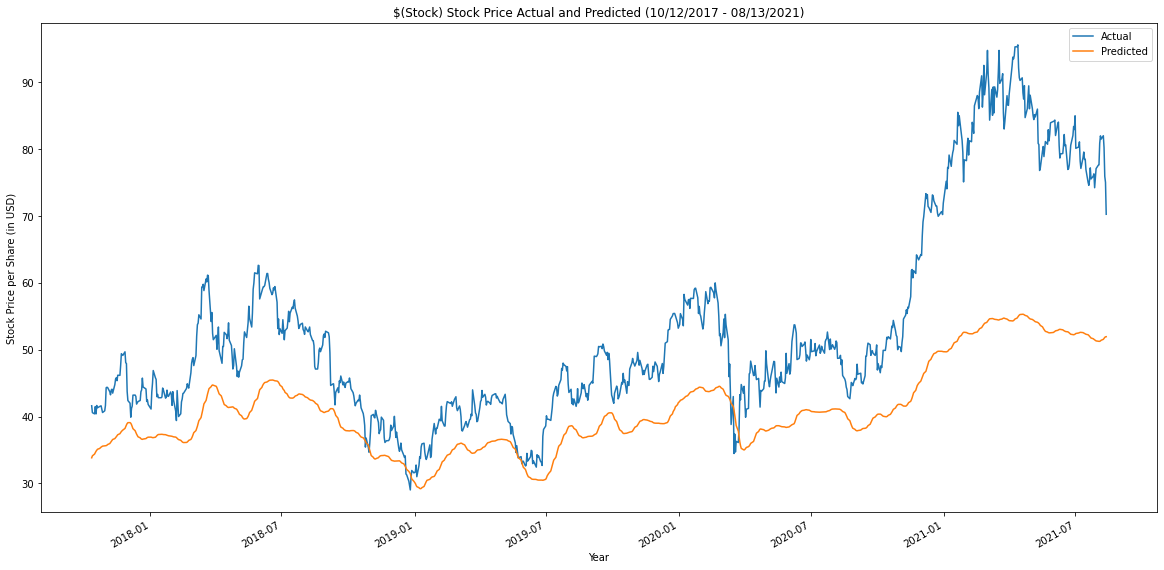

In [20]:
actual_predicted.plot(figsize=(20,10))
plt.title('$(Stock) Stock Price Actual and Predicted (10/12/2017 - 08/13/2021)')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc="best")
plt.show()